# ADCP Assessment 2.2: ADCP in the Sky

At the time that this notebook was created, there was an issue with the ADCP data displayed on the OOI Data Explorer (DE). The y-axis of pcolormesh plots on DE for ADCP time series have depths up to -500 m which puts these measurements "in the Sky". In this notebook, I will compare the datasets available from the Data Explorer ERDDAP server with datasets for the same sensors from OOINet. We hope this will clarify where the issue is in the data pipeline.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

from ooi_data_explorations.common import load_gc_thredds
from ooi_data_explorations.combine_data import combine_datasets

## Global Station PAPA Array: GP03FLMB-RIM01-02-ADCPSL007

### Dataset from Data Explorer ERDDAP server

In [2]:
# Load datasets from DE ERDDAP server 
# CSV imported into MultiIndex data frame
# gp_de_file = "~/code/qartod_testing/data/external/adcp_in_the_sky/ooi-gp03flmb-rim01-02-adcpsl007_ca5d_930f_6a0f.csv" # July 2013-June 2014
gp_de_file = "~/code/qartod_testing/data/external/adcp_in_the_sky/ooi-gp03flmb-rim01-02-adcpsl007_cf08_89fa_14e8.csv" # July 2013-2016
gp_de = pd.read_csv(gp_de_file, skiprows=[1], header=0, index_col=[0, 1], parse_dates=True)

The data we just imported was from this daily binned data view from Data Explorer: 
![GP03FLMB ADCP Jul 2013-2016](../data/external/adcp_in_the_sky/exported_chart_GP03FLMB_2013_2016.jpeg)

In [3]:
# Show contents of Global Station PAPA dataset from CSV
gp_de

eastward_sea_water_velocity  velprof_evl  \
time                      z                                                  
2013-07-24 07:26:00+00:00 -480.0                     0.120753       -0.002   
                          -470.0                     0.049463        0.007   
                          -460.0                     0.076618        0.052   
                          -450.0                     0.077163        0.005   
                          -440.0                     0.060183       -0.016   
...                                                       ...          ...   
2016-07-20 03:00:00+00:00 -11.0                      1.329435       -0.209   
                          -1.0                       1.382085        0.005   
                           9.0                       1.586498        0.334   
                           19.0                      2.024268          NaN   
                           49.0                      0.308178          NaN   

                                  velprof_err  northward_sea_water_velocity  \
time                      z                                                   
2013-07-24 07:26:00+00:00 -480.0          NaN                     -0.008474   
                          -470.0          NaN                     -0.016075   
                          -460.0          NaN                     -0.002379   
                          -450.0          NaN                     -0.010906   
                          -440.0          NaN                      0.008886   
...                                       ...                           ...   
2016-07-20 03:00:00+00:00 -11.0           NaN                     -1.125574   
                          -1.0            NaN                     -0.966977   
                           9.0            NaN                     -1.486265   
                           19.0           NaN                     -2.009225   
                           49.0           NaN                     -0.075573   

                                  upward_sea_water_velocity  
time                      z                                  
2013-07-24 07:26:00+00:00 -480.0                     -0.007  
                          -470.0                     -0.015  
                          -460.0                     -0.016  
                          -450.0                     -0.019  
                          -440.0                     -0.014  
...                                                     ...  
2016-07-20 03:00:00+00:00 -11.0                      -0.275  
                          -1.0                       -0.070  
                           9.0                        0.074  
                           19.0                      -0.100  
                           49.0                      -0.034  

[1742758 rows x 5 columns]

In [3]:
# Convert data frame to dataset
gp_de_ds = xr.Dataset.from_dataframe(gp_de)

# Need to convert the time coordinate as a datetime data type
gp_de_ds = gp_de_ds.assign_coords(time=(gp_de_ds.time.astype('datetime64[ns]')))

# Check contents
gp_de_ds

<xarray.Dataset>
Dimensions:                       (time: 26106, z: 624)
Coordinates:
  * time                          (time) datetime64[ns] 2013-07-24T07:26:00 ....
  * z                             (z) float64 -541.0 -537.0 ... 486.0 496.0
Data variables:
    eastward_sea_water_velocity   (time, z) float64 nan nan nan ... nan nan nan
    velprof_evl                   (time, z) float64 nan nan nan ... nan nan nan
    velprof_err                   (time, z) float64 nan nan nan ... nan nan nan
    northward_sea_water_velocity  (time, z) float64 nan nan nan ... nan nan nan
    upward_sea_water_velocity     (time, z) float64 nan nan nan ... nan nan nan

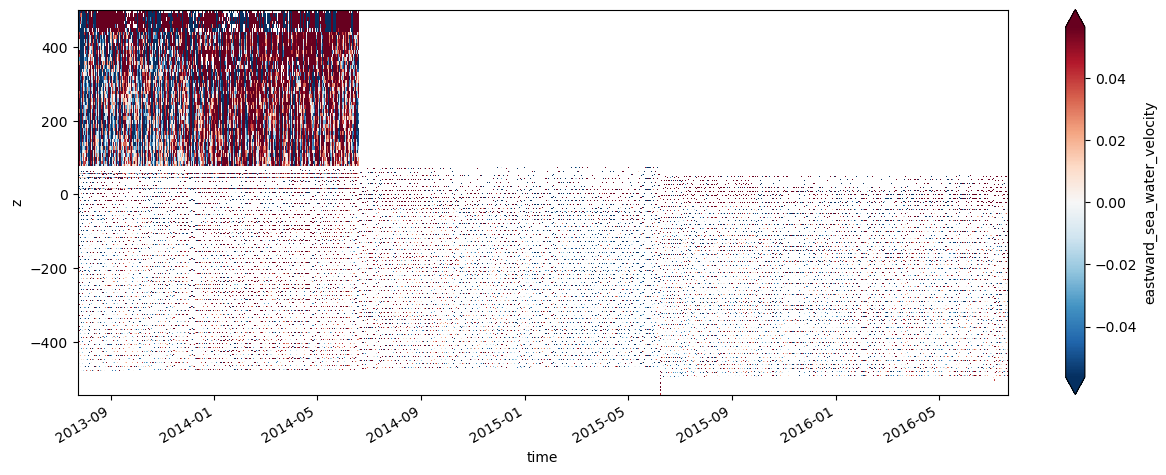

In [22]:
# Plot 2D eastward_sea_water_velocity variable
gp_de_ds["eastward_sea_water_velocity"].plot.pcolormesh(x="time", figsize=[15, 5], vmax=gp_de_ds["eastward_sea_water_velocity"].mean())

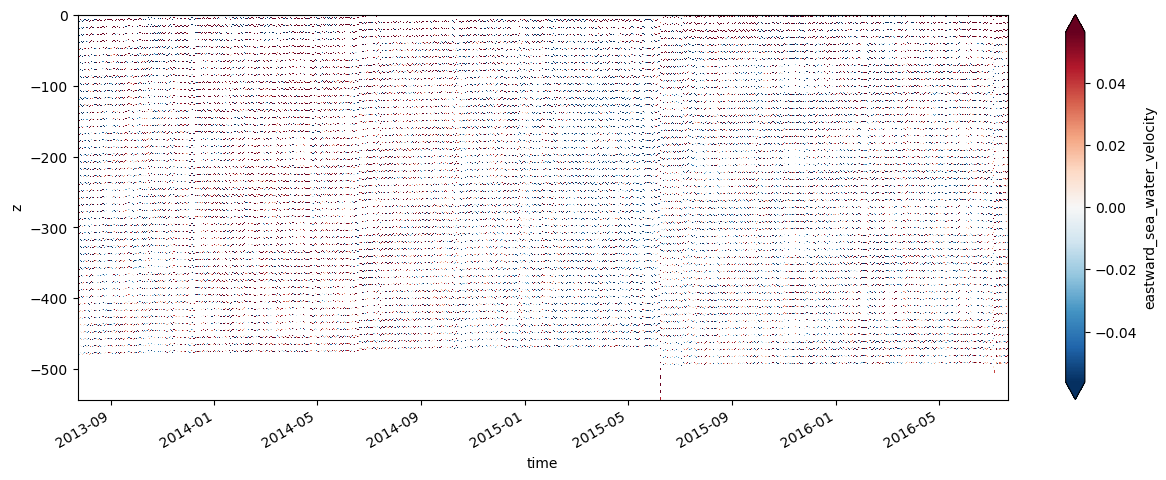

In [23]:
# Plot 2D eastward_sea_water_velocity variable for cell depths below the sea surface
gp_de_ds["eastward_sea_water_velocity"].sel(z=slice(0)).plot.pcolormesh(x="time", figsize=[15, 5], vmax=gp_de_ds["eastward_sea_water_velocity"].mean())

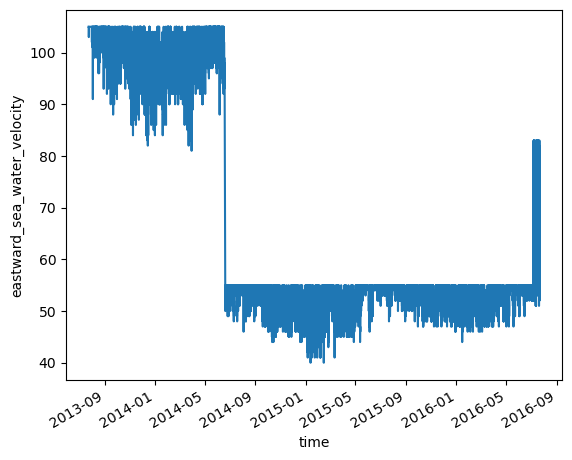

In [31]:
# Check and plot number of cells with data at each time step
numcells = gp_de_ds["eastward_sea_water_velocity"].count(dim="z")
numcells.plot()

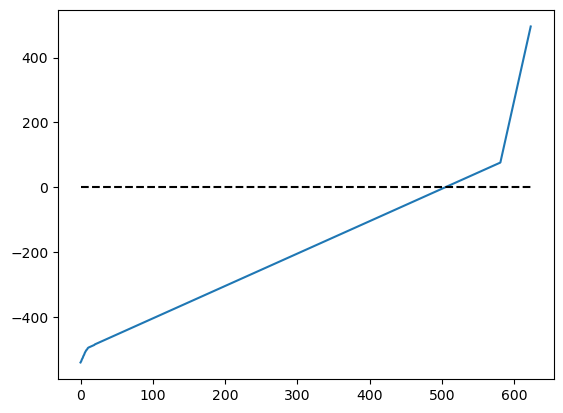

In [30]:
# Plot cell depths 
plt.plot(np.arange(gp_de_ds["z"].size), gp_de_ds["z"])
plt.hlines(0, 0, gp_de_ds["z"].size, colors='black', linestyles='dashed')

We expect some variation in cell depths between deployments, so the depth range with more cells per unit depth is the typical depth range for the ADCPS at this location.

### Compare data in the sky with depth-corrected data

In [4]:
# Index one time slice from Global PAPA dataset 
gpDE_1time = gp_de_ds.sel(time="2013-09-01T00:26:00").dropna(dim='z', how='all')
gpDE_1time

<xarray.Dataset>
Dimensions:                       (z: 103)
Coordinates:
    time                          datetime64[ns] 2013-09-01T00:26:00
  * z                             (z) float64 -477.0 -467.0 ... 486.0 496.0
Data variables:
    eastward_sea_water_velocity   (z) float64 0.01765 -0.04412 ... 0.2998 0.5689
    velprof_evl                   (z) float64 -0.052 -0.028 -0.021 ... 0.05 nan
    velprof_err                   (z) float64 nan nan nan nan ... nan nan nan
    northward_sea_water_velocity  (z) float64 0.03749 0.04056 ... -1.898 -1.941
    upward_sea_water_velocity     (z) float64 0.006 0.008 ... 0.018 -0.062

In [22]:
# Attempt to plot autocorrelation matrix of eastward sea water velocity with depth 
# (when I don't remember if it is possible to do this in one dimension)
outerprod = np.outer(gpDE_1time['eastward_sea_water_velocity'], gpDE_1time['eastward_sea_water_velocity'])
# outerprod

normalizedmaybe = np.zeros_like(outerprod)
for i, x in enumerate(outerprod): 
    normalizedmaybe[i] = x/(gpDE_1time['eastward_sea_water_velocity'][i].values**2)
# normalizedmaybe

sns.heatmap(normalizedmaybe, vmax=1, vmin=-1, center=0, square=True)

In [5]:
# Plot eastward velocity at depths below surface (x-axis) against eastward velocity
# at elevations above the surface (y-axis) with a line showing a 1:1
# relationship in the background.
eastvel_water = gpDE_1time["eastward_sea_water_velocity"].sel(z=slice(20)) 
# elevation of 20 m is within possible "normal" cell depth range
# and makes the water and sky sections nearly equal
eastvel_sky = gpDE_1time["eastward_sea_water_velocity"].sel(z=slice(20, 500))[1: ]

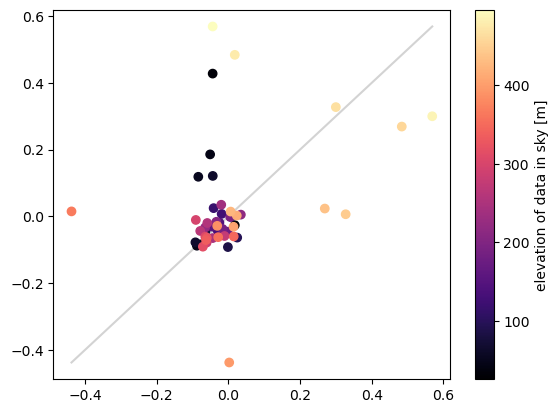

In [31]:
fig, ax = plt.subplots(1, 1)
plt.scatter(eastvel_water.values, eastvel_sky.values, c=eastvel_sky['z'].values, cmap='magma')
plt.colorbar(label="elevation of data in sky [m]")
xval = np.linspace(min(eastvel_water.values), max(eastvel_water.values), 50)
plt.plot(xval, xval, c="lightgray", zorder=-1)

So the plot above didn't work as well as I hoped because most of the points are near zero anyway. I guess there aren't many values in the upper left or lower right corners, so it's not like it couldn't be a 1:1 relationship. We just can't really get there from this.

Using these variables for eastward sea water velocity that I have now, I am going to try just plotting the velocity as a function of depth.

Text(0, 0.5, 'eastward sea water velocity [m s$^{-1}$?]')

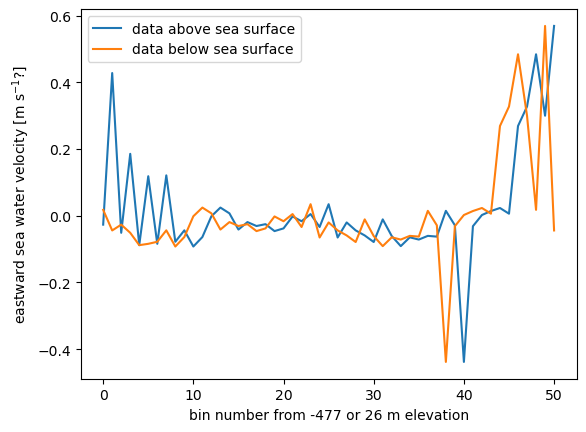

In [43]:
fig, ax = plt.subplots(1, 1)
plt.plot(eastvel_sky.values, label="data above sea surface")
plt.plot(eastvel_water.values, label="data below sea surface")
plt.legend()
ax.set_xlabel("bin number from -477 or 26 m elevation")
ax.set_ylabel("eastward sea water velocity [m s$^{-1}$?]")

Text(0, 0.5, 'eastward sea water velocity [m s$^{-1}$?]')

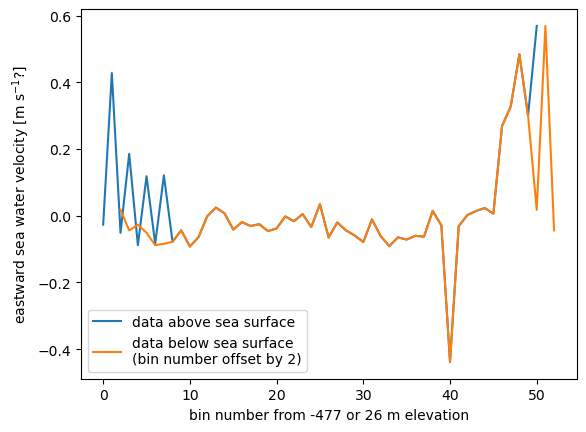

In [42]:
fig, ax = plt.subplots(1, 1)
plt.plot(eastvel_sky.values, label="data above sea surface")
plt.plot(np.arange(len(eastvel_water))+2, eastvel_water.values, label="data below sea surface \n(bin number offset by 2)")
plt.legend()
ax.set_xlabel("bin number from -477 or 26 m elevation")
ax.set_ylabel("eastward sea water velocity [m s$^{-1}$?]")

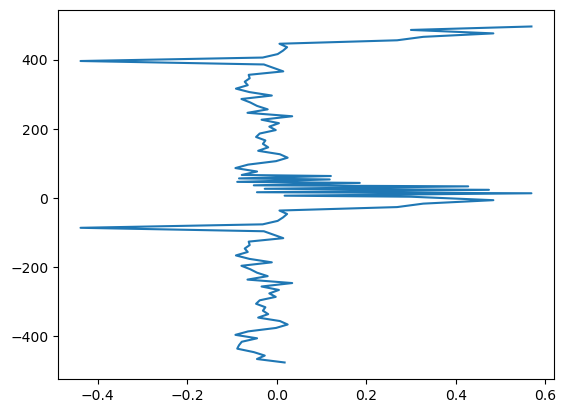

In [44]:
# quick plot of the eastward velocity profile as a function of elevation
plt.plot(gpDE_1time["eastward_sea_water_velocity"], gpDE_1time["z"])

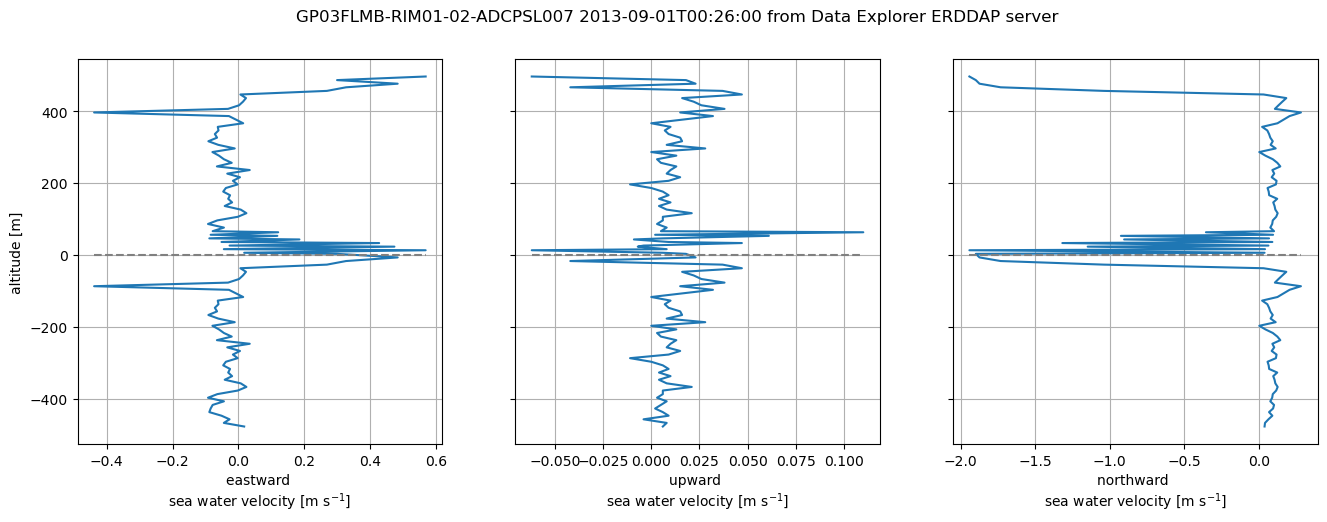

In [69]:
# quick plot of the eastward, northward, and upward velocity profile as a function of altitude
hline1x0 = gpDE_1time["eastward_sea_water_velocity"].min().values
hline1x1 = gpDE_1time["eastward_sea_water_velocity"].max().values
hline2x0 = gpDE_1time["upward_sea_water_velocity"].min().values
hline2x1 = gpDE_1time["upward_sea_water_velocity"].max().values
hline3x0 = gpDE_1time["northward_sea_water_velocity"].min().values
hline3x1 = gpDE_1time["northward_sea_water_velocity"].max().values

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 5))
plt.subplot(1, 3, 1)
plt.grid(visible=True)
plt.plot(gpDE_1time["eastward_sea_water_velocity"], gpDE_1time["z"])
axs[0].set_xlabel("eastward \nsea water velocity [m s$^{-1}$]")
plt.hlines(0, hline1x0, hline1x1, colors='gray', linestyles='dashed')
plt.subplot(1, 3, 2)
plt.grid(visible=True)
plt.plot(gpDE_1time["upward_sea_water_velocity"], gpDE_1time["z"])
axs[1].set_xlabel("upward \nsea water velocity [m s$^{-1}$]")
plt.hlines(0, hline2x0, hline2x1, colors='gray', linestyles='dashed')
plt.subplot(1, 3, 3)
plt.grid(visible=True)
plt.plot(gpDE_1time["northward_sea_water_velocity"], gpDE_1time["z"])
axs[2].set_xlabel("northward \nsea water velocity [m s$^{-1}$]")
plt.hlines(0, hline3x0, hline3x1, colors='gray', linestyles='dashed')
axs[0].set_ylabel("altitude [m]")
plt.suptitle("GP03FLMB-RIM01-02-ADCPSL007 2013-09-01T00:26:00 from Data Explorer ERDDAP server")
plt.show()

### Dataset from OOI Gold Copy

In [6]:
# Initialize parameters for gold copy data request from OOINet
gp_refdes = "GP03FLMB-RIM01-02-ADCPSL007"
gpsite, gpnode, gpsensor = gp_refdes.split("-", 2)

In [7]:
# Request telemtered, recovered host, and recovered instrument data to
# combine. The DE dataset of all deployments combines all delivery
# methods.
gptelem = load_gc_thredds(gpsite, gpnode, gpsensor, "telemetered", "adcps_jln_sio_mule_instrument", tag=".*ADCP.*\.nc$")
gphost = load_gc_thredds(gpsite, gpnode, gpsensor, "recovered_host", "adcps_jln_sio_mule_instrument", tag=".*ADCP.*\.nc$")
gpinst = load_gc_thredds(gpsite, gpnode, gpsensor, "recovered_inst", "adcp_velocity_earth", tag=".*ADCP.*\.nc$")

In [8]:
# Combine data delivery methods into a single dataset
gp_gc = combine_datasets(gptelem, gphost, gpinst, None)

In [9]:
# Create similar velocity profiles from gold copy data for the same timestamp
gpGC_1time = gp_gc.sel(time="2013-09-01T00:26:00", method="nearest")

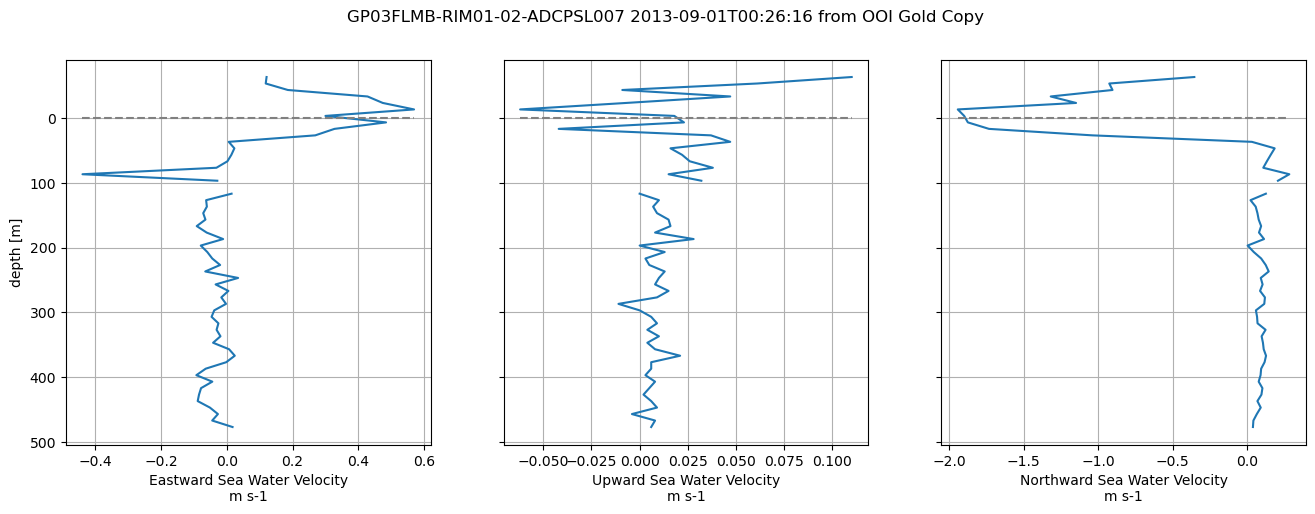

In [12]:
# plot of the eastward, northward, and upward velocity profile as a function of depth
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 5))
ax = 0
for var in gpGC_1time.variables:
    if "ward_seawater_velocity" in var:
        if ax < 3:
            velprofile = gpGC_1time[var]
            velprofile = velprofile.where(velprofile.values>velprofile._FillValue)
            hlinex0 = velprofile.min().values
            hlinex1 = velprofile.max().values

            plt.subplot(1, 3, ax+1)
            plt.grid(visible=True)
            plt.plot(velprofile.values, gpGC_1time["bin_depths"].values)
            axs[ax].invert_yaxis()
            axs[ax].set_xlabel(velprofile.long_name +"\n"+ velprofile.units)
            plt.hlines(0, hlinex0, hlinex1, colors='gray', linestyles='dashed')

            ax += 1

        else:
            continue
    else:
        continue
axs[0].set_ylabel("depth [m]")
plt.suptitle("GP03FLMB-RIM01-02-ADCPSL007 {timestamp:.19} from OOI Gold Copy".format(timestamp=gpGC_1time["time"].values))
plt.show()

### Compare Gold Copy and DE ERDDAP datasets

Now that we have all of our combined-stream datasets loaded into the notebook, we can check the range of depths in each dataset, and depth timeseries. There are four depth type parameters in the combined gold copy datasets: two with no instrument source in the attributes(`depth_from_pressure` and `non_zero_depth`) and two from the co-located CTDMO (`ctdmo_ghqr_sio_mule_instrument-depth` and `depth`). 
The datasets from the DE ERDDAP server have just one depth-type parameter: `z`.

In [19]:
# Check ranges of depth parameters
print(f"Station PAPA z range from DE:[{gp_de['z'].min()}, {gp_de['z'].max()}]")
print(f"Southern Ocean z range from DE:{np.ptp(gs_de['z'].values)}")

Station PAPA z range from DE:[<xarray.DataArray 'z' ()>
array(0.), <xarray.DataArray 'z' ()>
array(0.)]
Southern Ocean z range from DE:0.0


In [31]:
# Check ranges of gold copy depth parameters
print(f"Station PAPA depth_from_pressure range from DE:[{gp_gc['depth_from_pressure'].min().values}, {gp_gc['depth_from_pressure'].max().values}]")
print(f"Southern Ocean depth_from_pressure range from DE:[{gs_gc['depth_from_pressure'].min().values}, {gs_gc['depth_from_pressure'].max().values}]")

print(f"Station PAPA non_zero_depth range from DE:[{gp_gc['non_zero_depth'].min().values}, {gp_gc['non_zero_depth'].max().values}]")
print(f"Southern Ocean non_zero_depth range from DE:[{gs_gc['non_zero_depth'].min().values}, {gs_gc['non_zero_depth'].max().values}]")

print(f"Station PAPA ctdmo_ghqr_sio_mule_instrument-depth range from DE:[{gp_gc['ctdmo_ghqr_sio_mule_instrument-depth'].min().values}, {gp_gc['ctdmo_ghqr_sio_mule_instrument-depth'].max().values}]")
# print(f"Southern Ocean ctdmo_ghqr_sio_mule_instrument-depth range from DE:[{gs_gc['ctdmo_ghqr_sio_mule_instrument-depth'].min().values}, {gs_gc['ctdmo_ghqr_sio_mule_instrument-depth'].max().values}]")

print(f"Station PAPA depth range from DE:[{gp_gc['depth'].min().values}, {gp_gc['depth'].max().values}]")
# print(f"Southern Ocean depth range from DE:[{gs_gc['depth'].min().values}, {gs_gc['depth'].max().values}]")

Station PAPA depth_from_pressure range from DE:[481.8108615552479, 557.467162700832]
Southern Ocean depth_from_pressure range from DE:[18.897096405406707, 505.66615180355086]
Station PAPA non_zero_depth range from DE:[481.8108615552479, 557.467162700832]
Southern Ocean non_zero_depth range from DE:[18.897096405406707, 505.66615180355086]
Station PAPA ctdmo_ghqr_sio_mule_instrument-depth range from DE:[171.24286632302181, 565.9338353985949]
Station PAPA depth range from DE:[1.00874583311923, 565.9338353985949]


In [108]:
# What about the same DE ERDDAP velocity profile as above but I subtract the part that is in the water (including a little above the surface)?
# revisit this after comparing with goldcopy data 
# Is it the same as the gold copy data?
# plot of DE ERDDAP dataset with Gold Copy data subtracted from section of profile below the sea surface
gpDE_east = gpDE_1time["eastward_sea_water_velocity"]
gpGC_east = gpGC_1time["eastward_seawater_velocity"].where(gpGC_1time["eastward_seawater_velocity"]>velprofile._FillValue)
gpGC_east = gpGC_east.where(gpGC_1time["bin_depths"]>=0, drop=True)
end = len(gpGC_east) + 1
gpDE_east[-end:-1] = gpDE_east[-end:-1] - gpGC_east.values

gpDE_up = gpDE_1time["upward_sea_water_velocity"]
gpGC_up = gpGC_1time["upward_seawater_velocity"].where(gpGC_1time["upward_seawater_velocity"]>velprofile._FillValue)
gpGC_up = gpGC_up.where(gpGC_1time["bin_depths"]>=0, drop=True)
end = len(gpGC_up) + 1
gpDE_up[-end:-1] = gpDE_up[-end:-1] - gpGC_up.values

gpDE_north = gpDE_1time["northward_sea_water_velocity"]
gpGC_north = gpGC_1time["northward_seawater_velocity"].where(gpGC_1time["northward_seawater_velocity"]>velprofile._FillValue)
gpGC_north = gpGC_north.where(gpGC_1time["bin_depths"]>=0, drop=True)
end = len(gpGC_north) + 1
gpDE_north[-end:-1] = gpDE_north[-end:-1] - gpGC_north.values


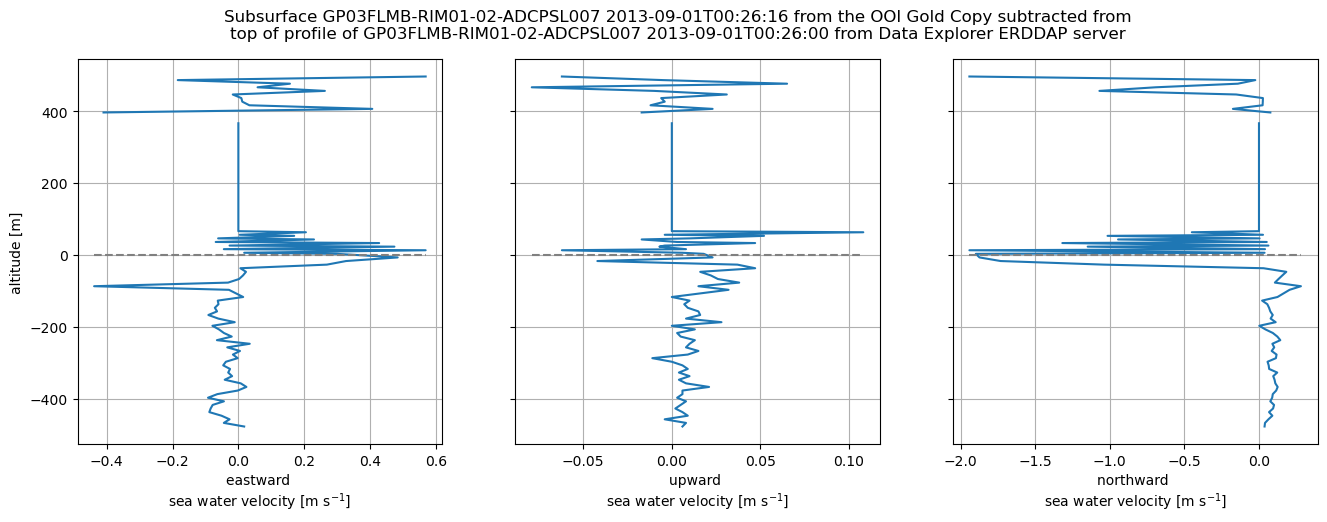

In [109]:
# plot of the eastward, northward, and upward velocity profile as a function of altitude
hline1x0 = gpDE_east.min().values
hline1x1 = gpDE_east.max().values
hline2x0 = gpDE_up.min().values
hline2x1 = gpDE_up.max().values
hline3x0 = gpDE_north.min().values
hline3x1 = gpDE_north.max().values

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 5))
plt.subplot(1, 3, 1)
plt.grid(visible=True)
plt.plot(gpDE_east.values, gpDE_east["z"])
axs[0].set_xlabel("eastward \nsea water velocity [m s$^{-1}$]")
plt.hlines(0, hline1x0, hline1x1, colors='gray', linestyles='dashed')
plt.subplot(1, 3, 2)
plt.grid(visible=True)
plt.plot(gpDE_up.values, gpDE_1time["z"])
axs[1].set_xlabel("upward \nsea water velocity [m s$^{-1}$]")
plt.hlines(0, hline2x0, hline2x1, colors='gray', linestyles='dashed')
plt.subplot(1, 3, 3)
plt.grid(visible=True)
plt.plot(gpDE_north.values, gpDE_north["z"])
axs[2].set_xlabel("northward \nsea water velocity [m s$^{-1}$]")
plt.hlines(0, hline3x0, hline3x1, colors='gray', linestyles='dashed')
axs[0].set_ylabel("altitude [m]")
plt.suptitle("Subsurface GP03FLMB-RIM01-02-ADCPSL007 2013-09-01T00:26:16 from the OOI Gold Copy subtracted from\ntop of profile of GP03FLMB-RIM01-02-ADCPSL007 2013-09-01T00:26:00 from Data Explorer ERDDAP server")
plt.show()

In [101]:
# plot of DE ERDDAP dataset with Gold Copy data subtracted from section of profile below the sea surface
gpDE_east = gpDE_1time["eastward_sea_water_velocity"]
gpGC_east = gpGC_1time["eastward_seawater_velocity"].where(gpGC_1time["eastward_seawater_velocity"]>velprofile._FillValue)
gpDE_east[0:55] = gpDE_east[0:55] - gpGC_east.values
gpDE_up = gpDE_1time["upward_sea_water_velocity"]
gpGC_up = gpGC_1time["upward_seawater_velocity"].where(gpGC_1time["upward_seawater_velocity"]>velprofile._FillValue)
gpDE_up[0:55] = gpDE_up[0:55] - gpGC_up.values
gpDE_north = gpDE_1time["northward_sea_water_velocity"]
gpGC_north = gpGC_1time["northward_seawater_velocity"].where(gpGC_1time["northward_seawater_velocity"]>velprofile._FillValue)
gpDE_north[0:55] = gpDE_north[0:55] - gpGC_north.values

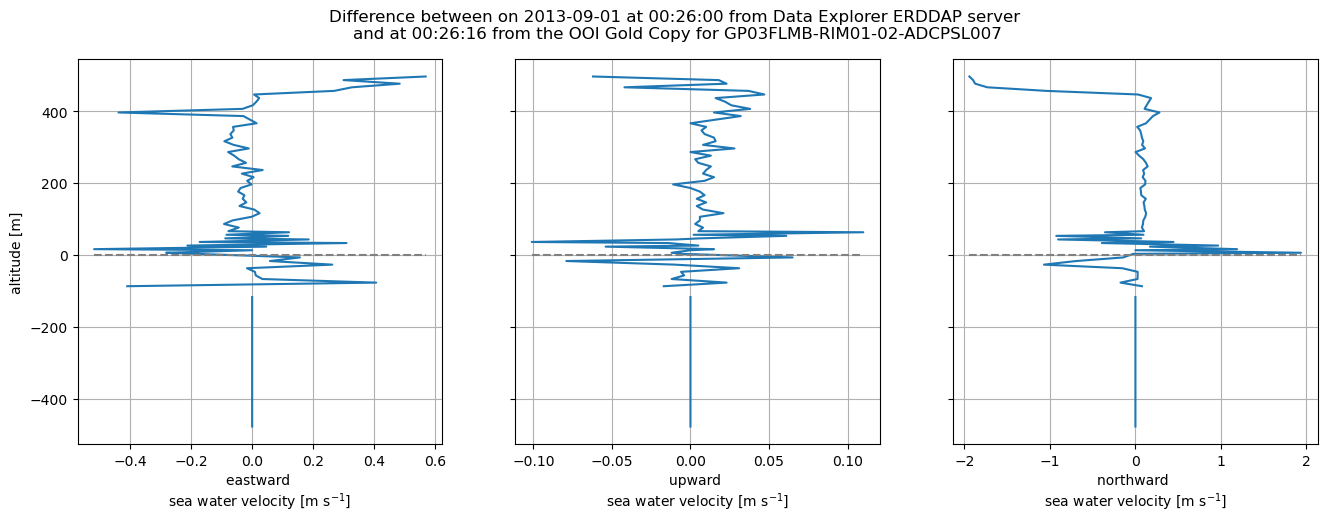

In [102]:
# plot of the eastward, northward, and upward velocity profile as a function of altitude
hline1x0 = gpDE_east.min().values
hline1x1 = gpDE_east.max().values
hline2x0 = gpDE_up.min().values
hline2x1 = gpDE_up.max().values
hline3x0 = gpDE_north.min().values
hline3x1 = gpDE_north.max().values

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 5))
plt.subplot(1, 3, 1)
plt.grid(visible=True)
plt.plot(gpDE_east.values, gpDE_east["z"])
axs[0].set_xlabel("eastward \nsea water velocity [m s$^{-1}$]")
plt.hlines(0, hline1x0, hline1x1, colors='gray', linestyles='dashed')
plt.subplot(1, 3, 2)
plt.grid(visible=True)
plt.plot(gpDE_up.values, gpDE_1time["z"])
axs[1].set_xlabel("upward \nsea water velocity [m s$^{-1}$]")
plt.hlines(0, hline2x0, hline2x1, colors='gray', linestyles='dashed')
plt.subplot(1, 3, 3)
plt.grid(visible=True)
plt.plot(gpDE_north.values, gpDE_north["z"])
axs[2].set_xlabel("northward \nsea water velocity [m s$^{-1}$]")
plt.hlines(0, hline3x0, hline3x1, colors='gray', linestyles='dashed')
axs[0].set_ylabel("altitude [m]")
plt.suptitle("Difference between on 2013-09-01 at 00:26:00 from Data Explorer ERDDAP server \nand at 00:26:16 from the OOI Gold Copy for GP03FLMB-RIM01-02-ADCPSL007")
plt.show()

In [13]:
# Plot of DE ERDDAP dataset with Gold Copy data overlay
gpDE_east = gpDE_1time["eastward_sea_water_velocity"]
gpGC_east = gpGC_1time["eastward_seawater_velocity"].where(gpGC_1time["eastward_seawater_velocity"]>velprofile._FillValue)

gpDE_up = gpDE_1time["upward_sea_water_velocity"]
gpGC_up = gpGC_1time["upward_seawater_velocity"].where(gpGC_1time["upward_seawater_velocity"]>velprofile._FillValue)

gpDE_north = gpDE_1time["northward_sea_water_velocity"]
gpGC_north = gpGC_1time["northward_seawater_velocity"].where(gpGC_1time["northward_seawater_velocity"]>velprofile._FillValue)

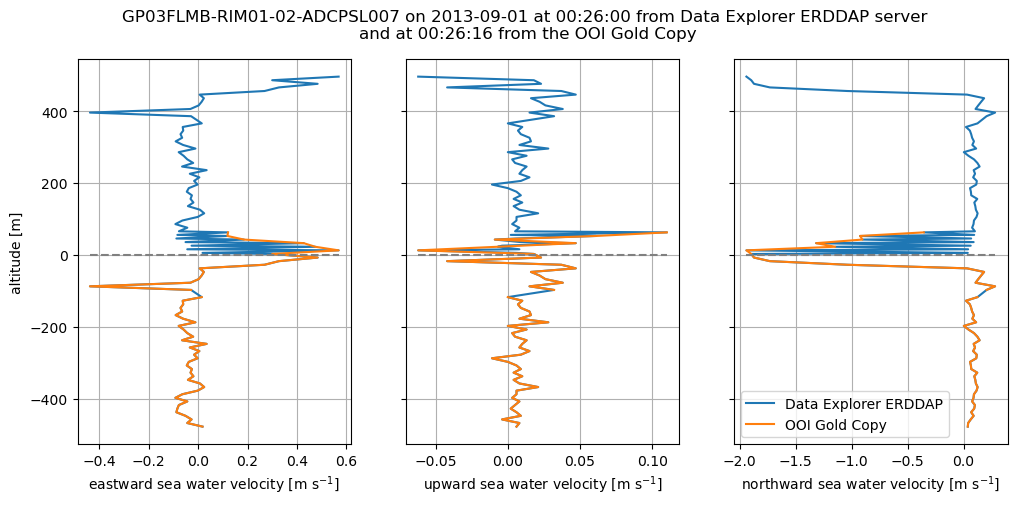

In [19]:
# plot of the eastward, northward, and upward velocity profile as a function of altitude
hline1x0 = gpDE_east.min().values
hline1x1 = gpDE_east.max().values
hline2x0 = gpDE_up.min().values
hline2x1 = gpDE_up.max().values
hline3x0 = gpDE_north.min().values
hline3x1 = gpDE_north.max().values

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.grid(visible=True)
plt.plot(gpDE_east.values, gpDE_east["z"])
plt.plot(gpGC_east.values, -1*gpGC_1time["bin_depths"])
axs[0].set_xlabel("eastward sea water velocity [m s$^{-1}$]")
plt.hlines(0, hline1x0, hline1x1, colors='gray', linestyles='dashed')

plt.subplot(1, 3, 2)
plt.grid(visible=True)
plt.plot(gpDE_up.values, gpDE_1time["z"])
plt.plot(gpGC_up.values, -1*gpGC_1time["bin_depths"])
axs[1].set_xlabel("upward sea water velocity [m s$^{-1}$]")
plt.hlines(0, hline2x0, hline2x1, colors='gray', linestyles='dashed')

plt.subplot(1, 3, 3)
plt.grid(visible=True)
plt.plot(gpDE_north.values, gpDE_north["z"], label="Data Explorer ERDDAP")
plt.plot(gpGC_north.values, -1*gpGC_1time["bin_depths"], label="OOI Gold Copy")
axs[2].set_xlabel("northward sea water velocity [m s$^{-1}$]")
plt.hlines(0, hline3x0, hline3x1, colors='gray', linestyles='dashed')

axs[0].set_ylabel("altitude [m]")
plt.suptitle("GP03FLMB-RIM01-02-ADCPSL007 on 2013-09-01 at 00:26:00 from Data Explorer ERDDAP server \nand at 00:26:16 from the OOI Gold Copy")
plt.legend()
plt.savefig("../data/processed/adcp_in_the_sky/GP03FLMB-RIM01-02-ADCPSL007_2013-09-01_DataExplorer-GoldCopy-Comparison.png")
plt.show()

## Global Southern Ocean Array: GS01SUMO-RII11-02-ADCPSN010

From Data Explorer, we are using daily binned data, including the eastward sea water velocity captured in this view: 
![GS01SUMO ADCP Nov 2015-Dec 2018](../data/external/adcp_in_the_sky/exported_chart_GS01SUMO.jpeg)

### Dataset from Data Explorer ERDDAP server

In [20]:
# Load datasets from DE ERDDAP server 
# CSV imported into MultiIndex data frame
gs_de_file = "~/code/qartod_testing/data/external/adcp_in_the_sky/ooi-gs01sumo-rii11-02-adcpsn010_e221_7c04_aa3f.csv" # Nov 2015-Dec 2018
gs_de = pd.read_csv(gs_de_file, skiprows=[1], header=0, index_col=[0, 1], parse_dates=True)

In [21]:
# Convert data frame to dataset
gs_de_ds = xr.Dataset.from_dataframe(gs_de)

# Need to convert the time coordinate as a datetime data type
gs_de_ds = gs_de_ds.assign_coords(time=(gs_de_ds.time.astype('datetime64[ns]')))

# Check contents
gs_de_ds

<xarray.Dataset>
Dimensions:                       (time: 14911, z: 631)
Coordinates:
  * time                          (time) datetime64[ns] 2015-11-30T08:04:00 ....
  * z                             (z) float64 -488.0 -487.0 ... 486.0 496.0
Data variables:
    eastward_sea_water_velocity   (time, z) float64 nan nan nan ... nan nan nan
    velprof_evl                   (time, z) float64 nan nan nan ... nan nan nan
    northward_sea_water_velocity  (time, z) float64 nan nan nan ... nan nan nan
    upward_sea_water_velocity     (time, z) float64 nan nan nan ... nan nan nan

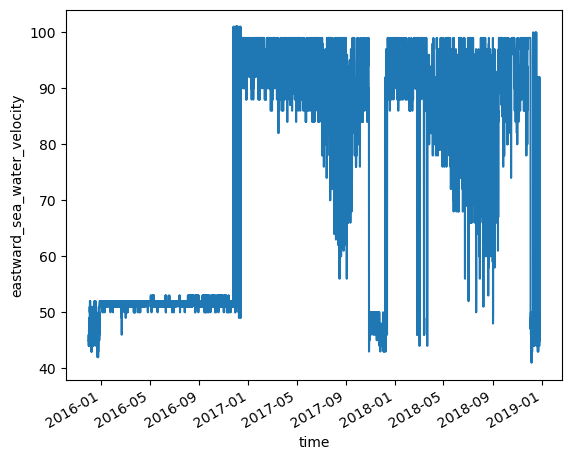

In [32]:
# Check and plot number of cells with data at each time step
numcells = gs_de_ds["eastward_sea_water_velocity"].count(dim="z")
numcells.plot()

In [22]:
# Extract datasets at a single timestamp from throughout
# the ADCP in the sky deployment (deploy 3)
gsDE_apr17 = gs_de_ds.sel(time="2017-04-05T12:00", method="nearest").dropna(dim="z", how="all")
gsDE_sept18 = gs_de_ds.sel(time="2018-09-03T12:00", method="nearest").dropna(dim="z", how="all")
gsDE_nov17 = gs_de_ds.sel(time="2017-11-14T12:00", method="nearest").dropna(dim="z", how="all")

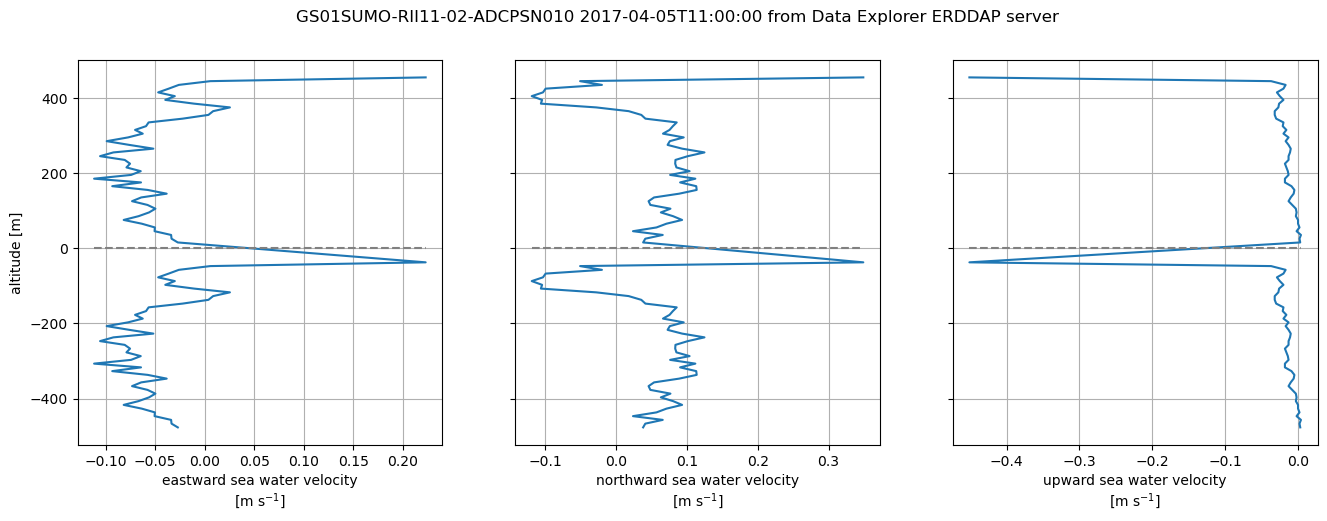

In [23]:
# 5 Apr 2017 
# plot of the eastward, northward, and upward velocity profile as a function of depth
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 5))
ax = 0
for var in gsDE_apr17.variables:
    if "ward_sea_water_velocity" in var:
        if ax < 3:
            velprofile = gsDE_apr17[var]
            hlinex0 = velprofile.min().values
            hlinex1 = velprofile.max().values
            
            plt.subplot(1, 3, ax+1)
            plt.grid(visible=True)
            plt.plot(velprofile.values, gsDE_apr17["z"].values)
            axs[ax].set_xlabel(" ".join(var.split("_"))+ "\n" + "[m s$^{-1}$]")
            plt.hlines(0, hlinex0, hlinex1, colors='gray', linestyles='dashed')
            
            ax += 1
        else:
            continue
    else:
        continue
axs[0].set_ylabel("altitude [m]")
plt.suptitle("GS01SUMO-RII11-02-ADCPSN010 {timestamp:.19} from Data Explorer ERDDAP server".format(
    timestamp=gsDE_apr17["time"].values))
plt.show()

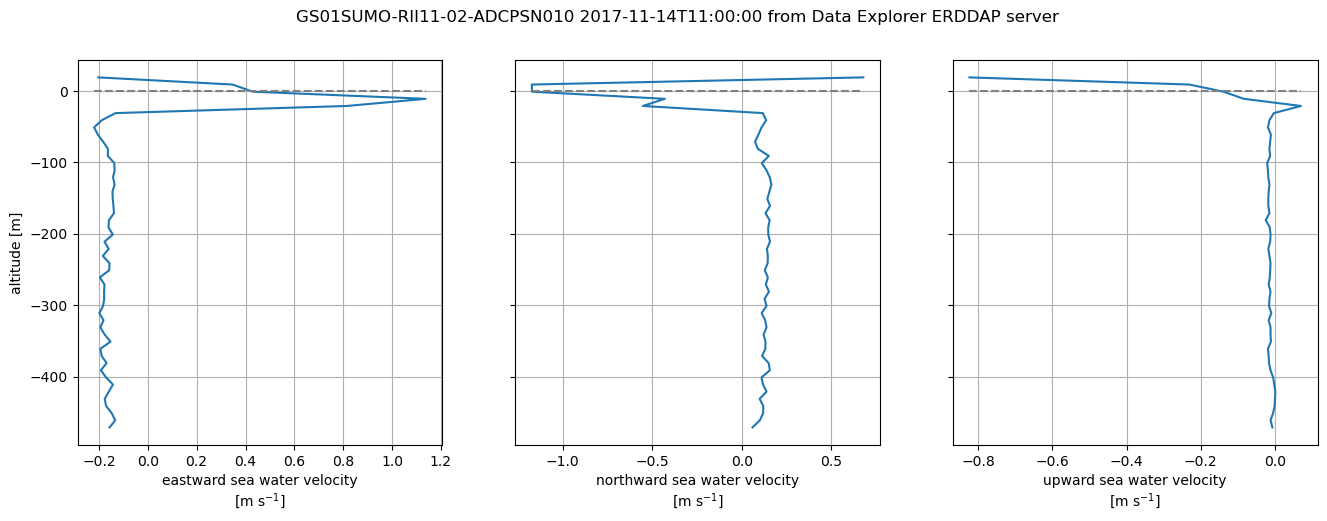

In [43]:
# 14 Nov 2017 
# plot of the eastward, northward, and upward velocity profile as a function of depth
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 5))
ax = 0
for var in gsDE_nov17.variables:
    if "ward_sea_water_velocity" in var:
        if ax < 3:
            velprofile = gsDE_nov17[var]
            hlinex0 = velprofile.min().values
            hlinex1 = velprofile.max().values
            
            plt.subplot(1, 3, ax+1)
            plt.grid(visible=True)
            plt.plot(velprofile.values, gsDE_nov17["z"].values)
            axs[ax].set_xlabel(" ".join(var.split("_"))+ "\n" + "[m s$^{-1}$]")
            plt.hlines(0, hlinex0, hlinex1, colors='gray', linestyles='dashed')
            
            ax += 1
        else:
            continue
    else:
        continue
axs[0].set_ylabel("altitude [m]")
plt.suptitle("GS01SUMO-RII11-02-ADCPSN010 {timestamp:.19} from Data Explorer ERDDAP server".format(
    timestamp=gsDE_nov17["time"].values))
plt.show()

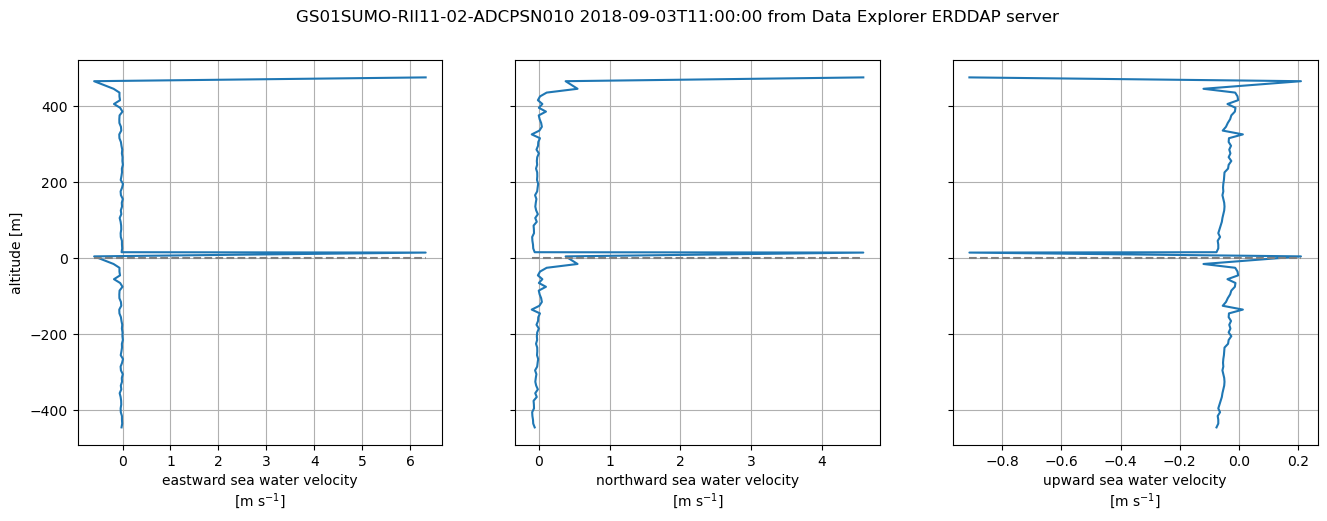

In [44]:
# 3 Sept 2018 
# plot of the eastward, northward, and upward velocity profile as a function of depth
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 5))
ax = 0
for var in gsDE_sept18.variables:
    if "ward_sea_water_velocity" in var:
        if ax < 3:
            velprofile = gsDE_sept18[var]
            hlinex0 = velprofile.min().values
            hlinex1 = velprofile.max().values
            
            plt.subplot(1, 3, ax+1)
            plt.grid(visible=True)
            plt.plot(velprofile.values, gsDE_sept18["z"].values)
            axs[ax].set_xlabel(" ".join(var.split("_"))+ "\n" + "[m s$^{-1}$]")
            plt.hlines(0, hlinex0, hlinex1, colors='gray', linestyles='dashed')
            
            ax += 1
        else:
            continue
    else:
        continue
axs[0].set_ylabel("altitude [m]")
plt.suptitle("GS01SUMO-RII11-02-ADCPSN010 {timestamp:.19} from Data Explorer ERDDAP server".format(
    timestamp=gsDE_sept18["time"].values))
plt.show()

### Dataset from OOI Gold Copy

In [24]:
# Initialize parameters for gold copy data request from OOINet
gs_refdes = "GS01SUMO-RII11-02-ADCPSN010"
gssite, gsnode, gssensor = gs_refdes.split("-", 2)

In [25]:
# Request telemtered, recovered host, and recovered instrument data to
# combine. The DE dataset of all deployments combines all delivery
# methods.
gstelem = load_gc_thredds(gssite, gsnode, gssensor, "telemetered", "adcps_jln_stc_instrument", tag=".*ADCP.*\.nc$")
gshost = load_gc_thredds(gssite, gsnode, gssensor, "recovered_host", "adcps_jln_stc_instrument_recovered", tag=".*ADCP.*\.nc$")
gsinst = load_gc_thredds(gssite, gsnode, gssensor, "recovered_inst", "adcp_velocity_earth", tag=".*ADCP.*\.nc$")

In [26]:
# Combine data delivery methods into a single dataset
gs_gc = combine_datasets(gstelem, gshost, gsinst, None)

In [27]:
# Create similar velocity profiles from gold copy data for the same timestamp
gsGC_apr17 = gs_gc.sel(time="2017-04-05T12:00", method="nearest")
gsGC_nov17 = gs_gc.sel(time="2017-11-14T12:00", method="nearest")
gsGC_sept18 = gs_gc.sel(time="2018-09-03T12:00", method="nearest")

### Compare Gold Copy and DE ERDDAP datasets

In [28]:
# Create fillval variable to clean up where statements below
fillval = gsGC_apr17["eastward_seawater_velocity"]._FillValue
# All bin depths for 2017-04-05T11:00 were replaced with the fill value
# Create best estimate of bin depths from depth from pressure 493 m and 52 bins with length of 10 m
bindepths = np.arange(-493, 20, 10)

In [53]:
# Plot of DE ERDDAP dataset with Gold Copy data overlay for 5 Apr 2017
gsDE_east = gsDE_apr17["eastward_sea_water_velocity"]
gsGC_east = gsGC_apr17["eastward_seawater_velocity"].where(gsGC_apr17["eastward_seawater_velocity"]>fillval)

gsDE_up = gsDE_apr17["upward_sea_water_velocity"]
gsGC_up = gsGC_apr17["upward_seawater_velocity"].where(gsGC_apr17["upward_seawater_velocity"]>fillval)

gsDE_north = gsDE_apr17["northward_sea_water_velocity"]
gsGC_north = gsGC_apr17["northward_seawater_velocity"].where(gsGC_apr17["northward_seawater_velocity"]>fillval)

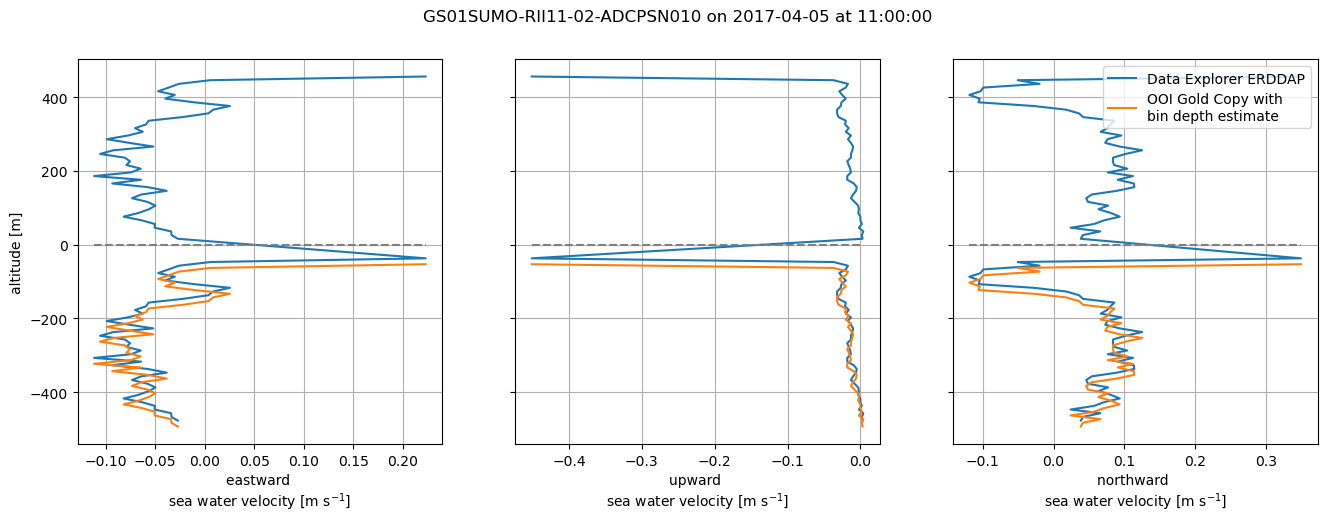

In [67]:
# plot of the eastward, northward, and upward velocity profile as a function of altitude
hline1x0 = gsDE_east.min().values
hline1x1 = gsDE_east.max().values
hline2x0 = gsDE_up.min().values
hline2x1 = gsDE_up.max().values
hline3x0 = gsDE_north.min().values
hline3x1 = gsDE_north.max().values

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 5))

plt.subplot(1, 3, 1)
plt.grid(visible=True)
plt.plot(gsDE_east.values, gsDE_east["z"])
plt.plot(gsGC_east.values, bindepths)
axs[0].set_xlabel("eastward \nsea water velocity [m s$^{-1}$]")
plt.hlines(0, hline1x0, hline1x1, colors='gray', linestyles='dashed')

plt.subplot(1, 3, 2)
plt.grid(visible=True)
plt.plot(gsDE_up.values, gsDE_up["z"])
plt.plot(gsGC_up.values, bindepths)
axs[1].set_xlabel("upward \nsea water velocity [m s$^{-1}$]")
plt.hlines(0, hline2x0, hline2x1, colors='gray', linestyles='dashed')

plt.subplot(1, 3, 3)
plt.grid(visible=True)
plt.plot(gsDE_north.values, gsDE_north["z"], label="Data Explorer ERDDAP")
plt.plot(gsGC_north.values, bindepths, label="OOI Gold Copy with\nbin depth estimate")
axs[2].set_xlabel("northward \nsea water velocity [m s$^{-1}$]")
plt.hlines(0, hline3x0, hline3x1, colors='gray', linestyles='dashed')

axs[0].set_ylabel("altitude [m]")
plt.suptitle("GS01SUMO-RII11-02-ADCPSN010 on 2017-04-05 at 11:00:00")
plt.legend(loc="upper right")
plt.show()

In [68]:
# Plot of DE ERDDAP dataset with Gold Copy data overlay for 14 Nov 2017
gsDE_east = gsDE_nov17["eastward_sea_water_velocity"]
gsGC_east = gsGC_nov17["eastward_seawater_velocity"].where(gsGC_nov17["eastward_seawater_velocity"]>fillval)

gsDE_up = gsDE_nov17["upward_sea_water_velocity"]
gsGC_up = gsGC_nov17["upward_seawater_velocity"].where(gsGC_nov17["upward_seawater_velocity"]>fillval)

gsDE_north = gsDE_nov17["northward_sea_water_velocity"]
gsGC_north = gsGC_nov17["northward_seawater_velocity"].where(gsGC_nov17["northward_seawater_velocity"]>fillval)

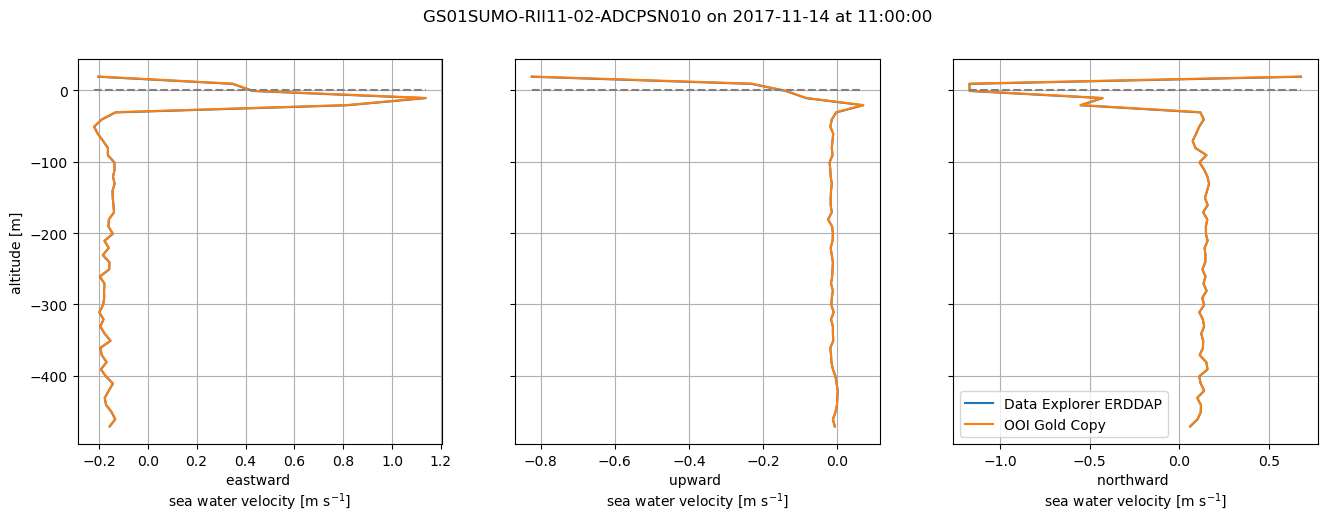

In [72]:
# plot of the eastward, northward, and upward velocity profile as a function of altitude
hline1x0 = gsDE_east.min().values
hline1x1 = gsDE_east.max().values
hline2x0 = gsDE_up.min().values
hline2x1 = gsDE_up.max().values
hline3x0 = gsDE_north.min().values
hline3x1 = gsDE_north.max().values

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 5))

plt.subplot(1, 3, 1)
plt.grid(visible=True)
plt.plot(gsDE_east.values, gsDE_east["z"])
plt.plot(gsGC_east.values, -1*gsGC_nov17["bin_depths"])
axs[0].set_xlabel("eastward \nsea water velocity [m s$^{-1}$]")
plt.hlines(0, hline1x0, hline1x1, colors='gray', linestyles='dashed')

plt.subplot(1, 3, 2)
plt.grid(visible=True)
plt.plot(gsDE_up.values, gsDE_up["z"])
plt.plot(gsGC_up.values, -1*gsGC_nov17["bin_depths"])
axs[1].set_xlabel("upward \nsea water velocity [m s$^{-1}$]")
plt.hlines(0, hline2x0, hline2x1, colors='gray', linestyles='dashed')

plt.subplot(1, 3, 3)
plt.grid(visible=True)
plt.plot(gsDE_north.values, gsDE_north["z"], label="Data Explorer ERDDAP")
plt.plot(gsGC_north.values, -1*gsGC_nov17["bin_depths"], label="OOI Gold Copy")
axs[2].set_xlabel("northward \nsea water velocity [m s$^{-1}$]")
plt.hlines(0, hline3x0, hline3x1, colors='gray', linestyles='dashed')

axs[0].set_ylabel("altitude [m]")
plt.suptitle("GS01SUMO-RII11-02-ADCPSN010 on 2017-11-14 at 11:00:00")
plt.legend()
plt.show()

In [91]:
# Plot of DE ERDDAP dataset with Gold Copy data overlay for 3 Sept 2018
gsDE_east = gsDE_sept18["eastward_sea_water_velocity"]
gsGC_east = gsGC_sept18["adcps_jln_eastward_seawater_velocity2"].where(gsGC_sept18["adcps_jln_eastward_seawater_velocity2"]>fillval)

gsDE_up = gsDE_sept18["upward_sea_water_velocity"]
gsGC_up = gsGC_sept18["adcps_jln_upward_seawater_velocity2"].where(gsGC_sept18["adcps_jln_upward_seawater_velocity2"]>fillval)

gsDE_north = gsDE_sept18["northward_sea_water_velocity"]
gsGC_north = gsGC_sept18["adcps_jln_northward_seawater_velocity2"].where(gsGC_sept18["adcps_jln_northward_seawater_velocity2"]>fillval)

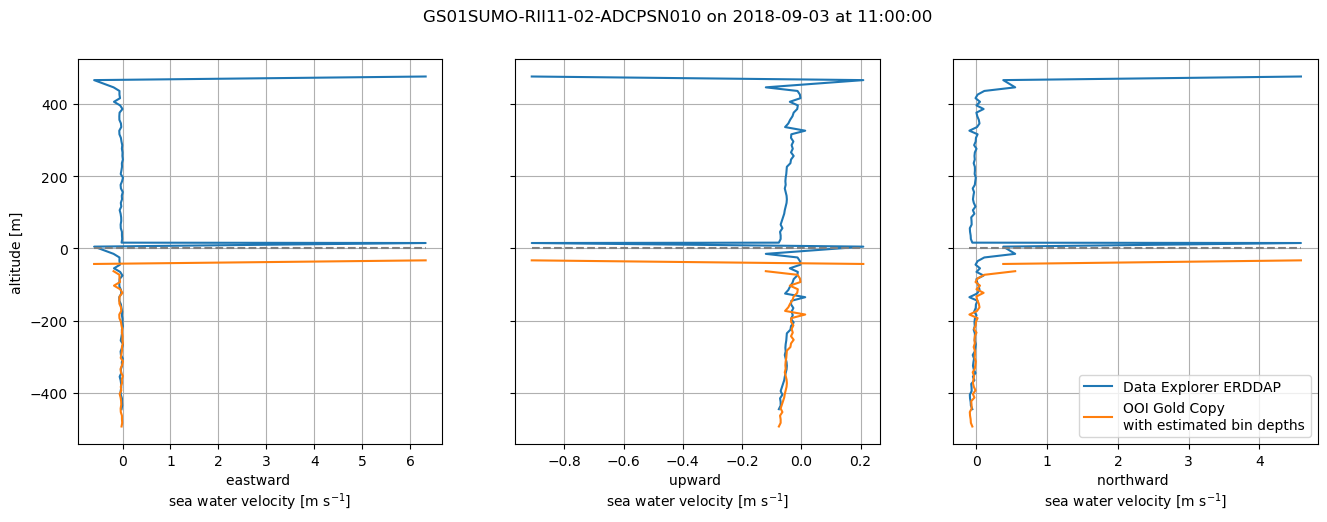

In [92]:
# plot of the eastward, northward, and upward velocity profile as a function of altitude
hline1x0 = gsDE_east.min().values
hline1x1 = gsDE_east.max().values
hline2x0 = gsDE_up.min().values
hline2x1 = gsDE_up.max().values
hline3x0 = gsDE_north.min().values
hline3x1 = gsDE_north.max().values

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 5))

plt.subplot(1, 3, 1)
plt.grid(visible=True)
plt.plot(gsDE_east.values, gsDE_east["z"])
plt.plot(gsGC_east.values, bindepths)
axs[0].set_xlabel("eastward \nsea water velocity [m s$^{-1}$]")
plt.hlines(0, hline1x0, hline1x1, colors='gray', linestyles='dashed')

plt.subplot(1, 3, 2)
plt.grid(visible=True)
plt.plot(gsDE_up.values, gsDE_up["z"])
plt.plot(gsGC_up.values, bindepths)
axs[1].set_xlabel("upward \nsea water velocity [m s$^{-1}$]")
plt.hlines(0, hline2x0, hline2x1, colors='gray', linestyles='dashed')

plt.subplot(1, 3, 3)
plt.grid(visible=True)
plt.plot(gsDE_north.values, gsDE_north["z"], label="Data Explorer ERDDAP")
plt.plot(gsGC_north.values, bindepths, label="OOI Gold Copy\nwith estimated bin depths")
axs[2].set_xlabel("northward \nsea water velocity [m s$^{-1}$]")
plt.hlines(0, hline3x0, hline3x1, colors='gray', linestyles='dashed')

axs[0].set_ylabel("altitude [m]")
plt.suptitle("GS01SUMO-RII11-02-ADCPSN010 on 2018-09-03 at 11:00:00")
plt.legend()
plt.show()

In two out of the three previous figures, I had to substitute an estimate of the bin depths for the `bin_depths` variable. After looking at each stream individually, I discovered that for 3 Sept 2018 there was no recovered instrument or recovered host data available. Additionally, the `bin_depths` parameter from the telemetered stream was an array of just the fill value or of NaNs for all of 2018. I would expect that this is true of bin depths from the telemetered stream from this sensor generally. 

In the last figure above, the water velocities are not from the same variable as the other plots, since there was no recovered instrument data. I had to use `adcps_jln_eastward_seawater_velocity2` and other similarly named variables.

Next, I will make the same figure for 15 Jan 2018, which I know from a plot of roll from the recovered instrument stream that there is recovered instrument data available and this date falls in the ADCP in the sky data on Data Explorer.

In [29]:
gsGC_jan18 = gs_gc.sel(time="2018-01-15T12:00", method="nearest")
gsDE_jan18 = gs_de_ds.sel(time="2018-01-15T12:00", method="nearest").dropna(dim="z", how="all")

In [30]:
# Plot of DE ERDDAP dataset with Gold Copy data overlay for 5 Apr 2017
gsDE_east = gsDE_jan18["eastward_sea_water_velocity"]
gsGC_east = gsGC_jan18["eastward_seawater_velocity"].where(gsGC_jan18["eastward_seawater_velocity"]>fillval)

gsDE_up = gsDE_jan18["upward_sea_water_velocity"]
gsGC_up = gsGC_jan18["upward_seawater_velocity"].where(gsGC_jan18["upward_seawater_velocity"]>fillval)

gsDE_north = gsDE_jan18["northward_sea_water_velocity"]
gsGC_north = gsGC_jan18["northward_seawater_velocity"].where(gsGC_jan18["northward_seawater_velocity"]>fillval)

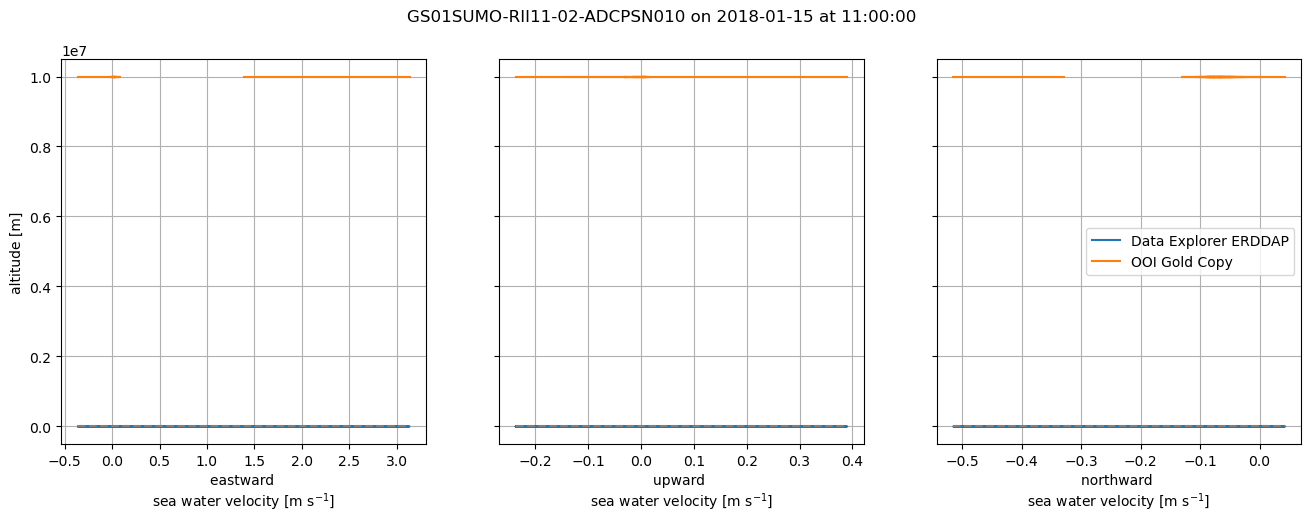

In [97]:
# plot of the eastward, northward, and upward velocity profile as a function of altitude
hline1x0 = gsDE_east.min().values
hline1x1 = gsDE_east.max().values
hline2x0 = gsDE_up.min().values
hline2x1 = gsDE_up.max().values
hline3x0 = gsDE_north.min().values
hline3x1 = gsDE_north.max().values

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 5))

plt.subplot(1, 3, 1)
plt.grid(visible=True)
plt.plot(gsDE_east.values, gsDE_east["z"])
plt.plot(gsGC_east.values, -1*gsGC_jan18["bin_depths"])
axs[0].set_xlabel("eastward \nsea water velocity [m s$^{-1}$]")
plt.hlines(0, hline1x0, hline1x1, colors='gray', linestyles='dashed')

plt.subplot(1, 3, 2)
plt.grid(visible=True)
plt.plot(gsDE_up.values, gsDE_up["z"])
plt.plot(gsGC_up.values, -1*gsGC_jan18["bin_depths"])
axs[1].set_xlabel("upward \nsea water velocity [m s$^{-1}$]")
plt.hlines(0, hline2x0, hline2x1, colors='gray', linestyles='dashed')

plt.subplot(1, 3, 3)
plt.grid(visible=True)
plt.plot(gsDE_north.values, gsDE_north["z"], label="Data Explorer ERDDAP")
plt.plot(gsGC_north.values, -1*gsGC_jan18["bin_depths"], label="OOI Gold Copy")
axs[2].set_xlabel("northward \nsea water velocity [m s$^{-1}$]")
plt.hlines(0, hline3x0, hline3x1, colors='gray', linestyles='dashed')

axs[0].set_ylabel("altitude [m]")
plt.suptitle("GS01SUMO-RII11-02-ADCPSN010 on 2018-01-15 at 11:00:00")
plt.legend()
plt.show()

I will try again one more time with the recovered instrument dataset only and not the combined dataset

In [31]:
gsGC_jan18 = gsinst.sel(time="2018-01-15T12:00", method="nearest")
gsDE_jan18 = gs_de_ds.sel(time="2018-01-15T12:00", method="nearest").dropna(dim="z", how="all")

In [32]:
# Plot of DE ERDDAP dataset with Gold Copy data overlay for 5 Apr 2017
gsDE_east = gsDE_jan18["eastward_sea_water_velocity"]
gsGC_east = gsGC_jan18["eastward_seawater_velocity"].where(gsGC_jan18["eastward_seawater_velocity"]>fillval)

gsDE_up = gsDE_jan18["upward_sea_water_velocity"]
gsGC_up = gsGC_jan18["upward_seawater_velocity"].where(gsGC_jan18["upward_seawater_velocity"]>fillval)

gsDE_north = gsDE_jan18["northward_sea_water_velocity"]
gsGC_north = gsGC_jan18["northward_seawater_velocity"].where(gsGC_jan18["northward_seawater_velocity"]>fillval)

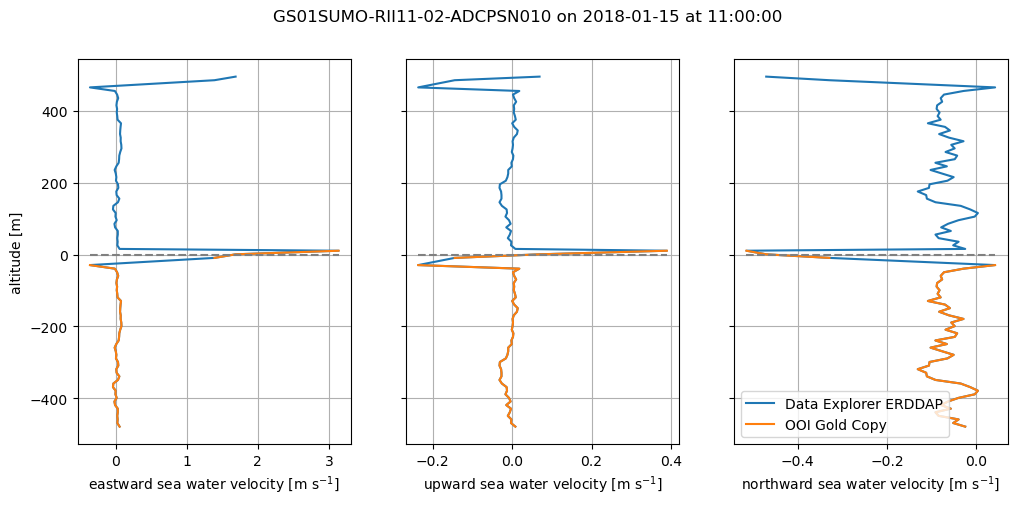

In [38]:
# plot of the eastward, northward, and upward velocity profile as a function of altitude
hline1x0 = gsDE_east.min().values
hline1x1 = gsDE_east.max().values
hline2x0 = gsDE_up.min().values
hline2x1 = gsDE_up.max().values
hline3x0 = gsDE_north.min().values
hline3x1 = gsDE_north.max().values

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.grid(visible=True)
plt.plot(gsDE_east.values, gsDE_east["z"])
plt.plot(gsGC_east.values, -1*gsGC_jan18["bin_depths"])
axs[0].set_xlabel("eastward sea water velocity [m s$^{-1}$]")
plt.hlines(0, hline1x0, hline1x1, colors='gray', linestyles='dashed')

plt.subplot(1, 3, 2)
plt.grid(visible=True)
plt.plot(gsDE_up.values, gsDE_up["z"])
plt.plot(gsGC_up.values, -1*gsGC_jan18["bin_depths"])
axs[1].set_xlabel("upward sea water velocity [m s$^{-1}$]")
plt.hlines(0, hline2x0, hline2x1, colors='gray', linestyles='dashed')

plt.subplot(1, 3, 3)
plt.grid(visible=True)
plt.plot(gsDE_north.values, gsDE_north["z"], label="Data Explorer ERDDAP")
plt.plot(gsGC_north.values, -1*gsGC_jan18["bin_depths"], label="OOI Gold Copy")
axs[2].set_xlabel("northward sea water velocity [m s$^{-1}$]")
plt.hlines(0, hline3x0, hline3x1, colors='gray', linestyles='dashed')

axs[0].set_ylabel("altitude [m]")
plt.suptitle("GS01SUMO-RII11-02-ADCPSN010 on 2018-01-15 at 11:00:00")
plt.legend(loc="lower left")
plt.savefig("../data/processed/adcp_in_the_sky/GS01SUMO-RII11-02-ADCPSN010_2018-01-15_DataExplorer-GoldCopy-Comparison.png")
plt.show()

I'm curious to see how the plot looks if I try to use the bins at the end of the DE bin array for the gold copy data.

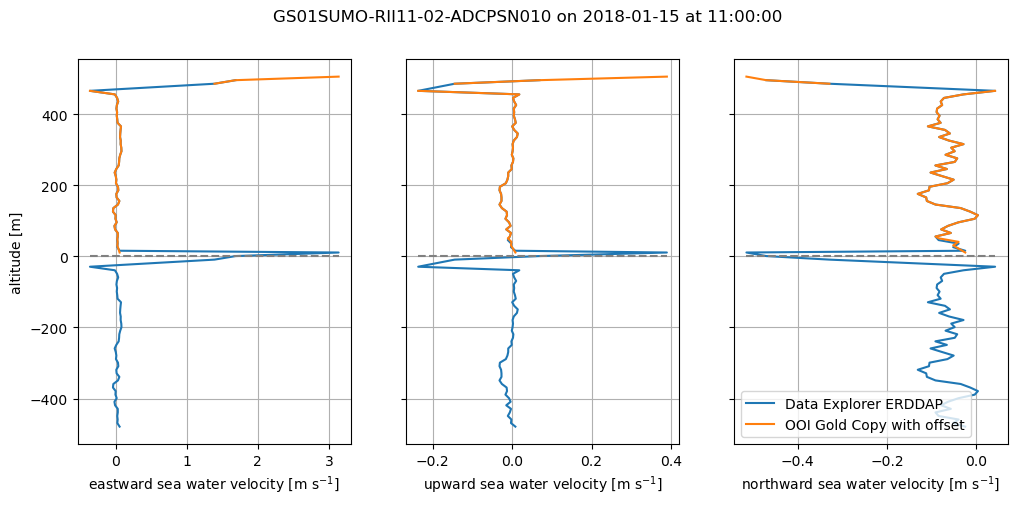

In [40]:
# plot of the eastward, northward, and upward velocity profile as a function of altitude
hline1x0 = gsDE_east.min().values
hline1x1 = gsDE_east.max().values
hline2x0 = gsDE_up.min().values
hline2x1 = gsDE_up.max().values
hline3x0 = gsDE_north.min().values
hline3x1 = gsDE_north.max().values

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.grid(visible=True)
plt.plot(gsDE_east.values, gsDE_east["z"])
plt.plot(gsGC_east.values, gsDE_east["z"][-len(gsGC_east):]+40)
axs[0].set_xlabel("eastward sea water velocity [m s$^{-1}$]")
plt.hlines(0, hline1x0, hline1x1, colors='gray', linestyles='dashed')

plt.subplot(1, 3, 2)
plt.grid(visible=True)
plt.plot(gsDE_up.values, gsDE_up["z"])
plt.plot(gsGC_up.values, gsDE_up["z"][-len(gsGC_up):]+40)
axs[1].set_xlabel("upward sea water velocity [m s$^{-1}$]")
plt.hlines(0, hline2x0, hline2x1, colors='gray', linestyles='dashed')

plt.subplot(1, 3, 3)
plt.grid(visible=True)
plt.plot(gsDE_north.values, gsDE_north["z"], label="Data Explorer ERDDAP")
plt.plot(gsGC_north.values, gsDE_north["z"][-len(gsGC_north):]+40, label="OOI Gold Copy with offset")
axs[2].set_xlabel("northward sea water velocity [m s$^{-1}$]")
plt.hlines(0, hline3x0, hline3x1, colors='gray', linestyles='dashed')

axs[0].set_ylabel("altitude [m]")
plt.suptitle("GS01SUMO-RII11-02-ADCPSN010 on 2018-01-15 at 11:00:00")
plt.legend()
plt.savefig("../data/processed/adcp_in_the_sky/GS01SUMO-RII11-02-ADCPSN010_2018-01-15_DataExplorer-GoldCopy-offset.png")
plt.show()